## Pipeline Exploration
In this notebook I explored some options with PCA pipelines.  While PCA is somewhat helpful, it really only brings the accuracy of outcome selection up to ~55%.  PCA identified the home streak and the away win percentage to be the most valuable features. Next I will explore what happens if I include run diffrential

4/1/2020

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from numpy import interp
df = pd.read_csv("2019_all.csv", header=None)
df

,0,1,2,3,4,5,6,7
0,Date,Home_Win,Home,Away,Home_Streak,Away_Streak,Home_Win_Percentage,Away_Win_Percentage
1,thursday mar 28,W,OAK,LAA,-2,0,0.0,0.0
2,friday mar 29,L,OAK,LAA,1,-1,0.3333333333333333,0.0
3,saturday mar 30,W,OAK,LAA,-1,1,0.25,0.5
4,sunday mar 31,W,OAK,LAA,1,-1,0.4,0.3333333333333333
...,...,...,...,...,...,...,...,...
2425,sunday apr 14,L,NYY,CHW,1,-1,0.42857142857142855,0.3076923076923077
2426,thursday jun 13,W,CHW,NYY,1,-1,0.4848484848484849,0.6212121212121212
2427,friday jun 14,W,CHW,NYY,2,-2,0.4925373134328358,0.6119402985074627
2428,saturday jun 15,L,CHW,NYY,3,-3,0.5,0.6029411764705882


In [23]:
X = df.loc[1:,4:].values
y = df.loc[1:,1].values.ravel()
#create win/loss mask
wins = df.loc[1:,1] == 'W'
losses = df.loc[1:,1] != 'W'

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)
le = LabelEncoder()
y_label = le.fit_transform(y)
le.transform(['L','W'])

array([0, 1], dtype=int64)

In [26]:
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
# define a matrix
A = array(X_transform)

# calculate the mean of each column
M = mean(A.T, axis=1)

# center columns by subtracting column means
C = A - M

# calculate covariance matrix of centered matrix. This is how much each columns varies with other columns
V = cov(C.T)

# eigendecomposition of covariance matrix.  The larger the eigenvalue, the more it matters
values, vectors = eig(V)
print(f'Eigenvalues: {values}')

# project data using the covariance matrix and the eigenvectors
P = vectors.T.dot(C.T)

xval = np.array([item[0] for item in P.T])
yval = np.array([item[3] for item in P.T])

Eigenvalues: [1.8261137  0.41690137 0.79970396 0.95892842]


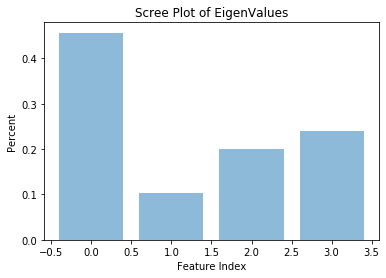

In [27]:
def create_scree(vector):
    total = sum(vector)
    percent = vector/total
    return percent

import matplotlib.pyplot as plt

plt.title('Scree Plot of EigenValues')
plt.ylabel('Percent')
plt.xlabel('Feature Index')
plt.bar([x for x in range(len(values))], create_scree(values), align='center', alpha=0.5)
plt.show()

## There is no separation of the data using PCA

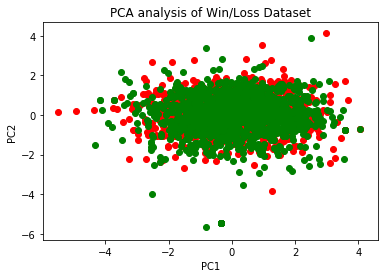

In [28]:
import matplotlib.pyplot as plt

#plot loses as red and wins as green
plt.scatter(xval[losses], yval[losses], color='red')                            
plt.scatter(xval[wins], yval[wins], color='green')

plt.title('PCA analysis of Win/Loss Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

## PCA --> Logistic Pipeline

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X_transform, y_label, 
                     test_size=0.20,
                     stratify=y_label,
                     random_state=1)

In [30]:
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

In [31]:
from sklearn.model_selection import StratifiedKFold    

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
#This is for demonstration purposes only: just use the  cross validation scorer below
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [822 926], Acc: 0.569
Fold:  2, Class dist.: [822 926], Acc: 0.533
Fold:  3, Class dist.: [822 926], Acc: 0.549
Fold:  4, Class dist.: [822 927], Acc: 0.546
Fold:  5, Class dist.: [823 926], Acc: 0.598
Fold:  6, Class dist.: [823 926], Acc: 0.552
Fold:  7, Class dist.: [823 926], Acc: 0.567
Fold:  8, Class dist.: [823 926], Acc: 0.572
Fold:  9, Class dist.: [823 926], Acc: 0.490
Fold: 10, Class dist.: [823 926], Acc: 0.577

CV accuracy: 0.555 +/- 0.028


# PCA -> NN Pipeline

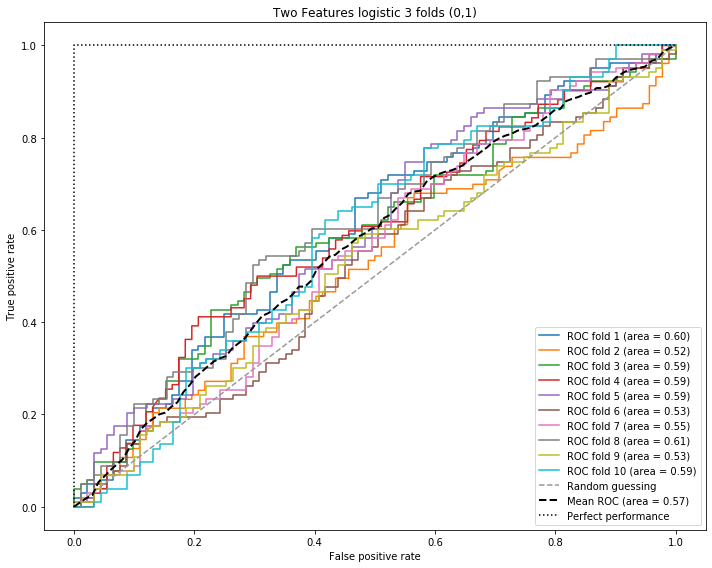

In [32]:
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        MLPClassifier(activation = "logistic", 
                                      solver='sgd',
                                      learning_rate_init = 0.1,
                                      learning_rate = "constant",
                                      momentum = 0.1,
                                      max_iter = 10000))
                    
# here we are selecting only 2 features from the dataset
X_train2 = X_train
#[:, [0,3]]
    
#You can set the cross validator here with the number of splits
cv = list(StratifiedKFold(n_splits=10).split(X_train, y_train))

fig = plt.figure(figsize=(10, 8))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    #Xtrain2 is used here for the fit, using only the features chosen above.  If you use the Xtrain data it will get 100%
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title("Two Features logistic 3 folds (0,1)")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
#plt.savefig('2_features_3folds.png', dpi=300)
plt.show()

## NN results

In [33]:
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
#This is for demonstration purposes only: just use the  cross validation scorer below
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [822 926], Acc: 0.503
Fold:  2, Class dist.: [822 926], Acc: 0.564
Fold:  3, Class dist.: [822 926], Acc: 0.564
Fold:  4, Class dist.: [822 927], Acc: 0.572
Fold:  5, Class dist.: [823 926], Acc: 0.536
Fold:  6, Class dist.: [823 926], Acc: 0.541
Fold:  7, Class dist.: [823 926], Acc: 0.536
Fold:  8, Class dist.: [823 926], Acc: 0.577
Fold:  9, Class dist.: [823 926], Acc: 0.510
Fold: 10, Class dist.: [823 926], Acc: 0.588

CV accuracy: 0.549 +/- 0.027
